In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Weather/san-francisco.csv')
dfi

,DATE,WND_DEG,WND_SPEED[m/s],VIS[m],TMP[C],DEW[C],AP[hPa],CIG[m]
0,2024-01-01 00:00:00,20.0,2.1,16093.0,13.3,10.2,1018.6,2286.0
1,2023-12-31 23:00:00,30.0,2.1,16093.0,13.9,9.4,1018.6,2286.0
2,2023-12-31 22:00:00,NaN,1.5,16093.0,13.3,9.4,1018.6,1006.0
3,2023-12-31 21:00:00,50.0,2.6,16046.5,13.9,10.6,1019.0,4572.0
4,2023-12-31 20:00:00,80.0,3.1,16093.0,12.8,10.6,1019.6,4267.0
...,...,...,...,...,...,...,...,...
446006,1973-01-01 04:00:00,340.0,3.6,24000.0,10.0,-2.0,1024.7,22000.0
446007,1973-01-01 03:00:00,NaN,6.2,24000.0,10.6,-0.6,1023.7,22000.0
446008,1973-01-01 02:00:00,NaN,6.1,24000.0,13.0,-2.0,1023.7,22000.0
446009,1973-01-01 01:00:00,340.0,6.7,70000.0,12.0,-1.0,1023.7,22000.0


In [3]:
df = dfi.loc[dfi['DATE'] > '2023-06-01']
df

,DATE,WND_DEG,WND_SPEED[m/s],VIS[m],TMP[C],DEW[C],AP[hPa],CIG[m]
0,2024-01-01 00:00:00,20.0,2.10,16093.0,13.3,10.20,1018.6,2286.0
1,2023-12-31 23:00:00,30.0,2.10,16093.0,13.9,9.40,1018.6,2286.0
2,2023-12-31 22:00:00,NaN,1.50,16093.0,13.3,9.40,1018.6,1006.0
3,2023-12-31 21:00:00,50.0,2.60,16046.5,13.9,10.60,1019.0,4572.0
4,2023-12-31 20:00:00,80.0,3.10,16093.0,12.8,10.60,1019.6,4267.0
...,...,...,...,...,...,...,...,...
5132,2023-06-01 04:00:00,250.0,5.70,16093.0,13.3,8.90,1011.7,11244.0
5133,2023-06-01 03:00:00,245.0,7.45,16093.0,13.9,8.90,1011.5,22000.0
5134,2023-06-01 02:00:00,260.0,7.20,16093.0,15.0,9.40,1011.5,488.0
5135,2023-06-01 01:00:00,250.0,8.75,16093.0,15.0,9.15,1011.5,11274.5


In [4]:
df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'
, 'TMP[C]': 'tempm', 'DEW[C]': 'dewptm', 'AP[hPa]':'press','CIG[m]':'ceil'}, inplace=True)
df = df[['wind_sp','tempm','press','dewptm']]
df = df.dropna()
df = df.reset_index(drop=True)
df

/tmp/ipykernel_67538/932233946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'


,wind_sp,tempm,press,dewptm
0,2.10,13.3,1018.6,10.20
1,2.10,13.9,1018.6,9.40
2,1.50,13.3,1018.6,9.40
3,2.60,13.9,1019.0,10.60
4,3.10,12.8,1019.6,10.60
...,...,...,...,...
5130,5.70,13.3,1011.7,8.90
5131,7.45,13.9,1011.5,8.90
5132,7.20,15.0,1011.5,9.40
5133,8.75,15.0,1011.5,9.15


In [5]:
df['nxt_target'] = df['dewptm'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5135 entries, 0 to 5134
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wind_sp     5135 non-null   float64
 1   tempm       5135 non-null   float64
 2   press       5135 non-null   float64
 3   dewptm      5135 non-null   float64
 4   nxt_target  5135 non-null   float64
dtypes: float64(5)
memory usage: 200.7 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,wind_sp,tempm,press,dewptm,nxt_target
0,2.1,13.3,1018.6,10.2,9.4
1,2.1,13.9,1018.6,9.4,9.4
2,1.5,13.3,1018.6,9.4,10.6
3,2.6,13.9,1019.0,10.6,10.6
4,3.1,12.8,1019.6,10.6,10.0
...,...,...,...,...,...
4103,8.8,21.7,1014.6,12.2,12.2
4104,8.8,21.1,1014.9,12.2,12.2
4105,6.7,22.2,1015.2,12.2,11.7
4106,7.7,21.1,1015.9,11.7,11.7


In [8]:
train.iloc[:,-1:]

,nxt_target
0,9.4
1,9.4
2,10.6
3,10.6
4,10.0
...,...
4103,12.2
4104,12.2
4105,11.7
4106,11.7


In [9]:
train.iloc[:,:4]

,wind_sp,tempm,press,dewptm
0,2.1,13.3,1018.6,10.2
1,2.1,13.9,1018.6,9.4
2,1.5,13.3,1018.6,9.4
3,2.6,13.9,1019.0,10.6
4,3.1,12.8,1019.6,10.6
...,...,...,...,...
4103,8.8,21.7,1014.6,12.2
4104,8.8,21.1,1014.9,12.2
4105,6.7,22.2,1015.2,12.2
4106,7.7,21.1,1015.9,11.7


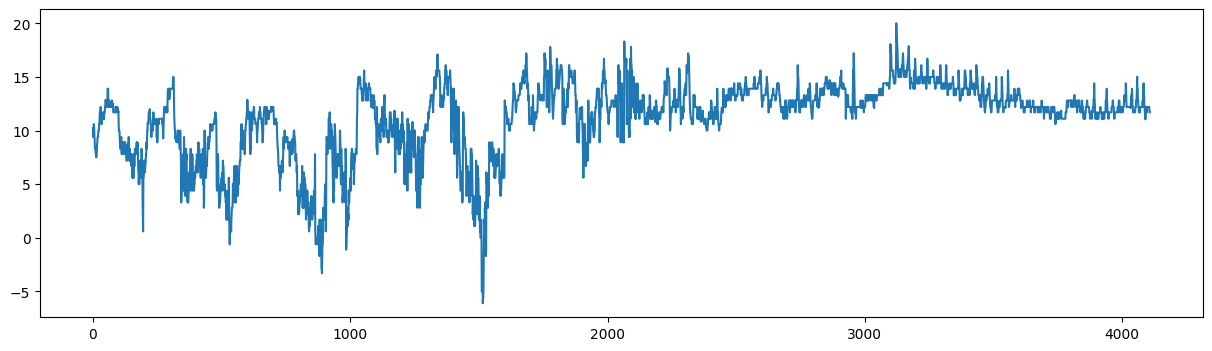

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["dewptm"])
plt.show()

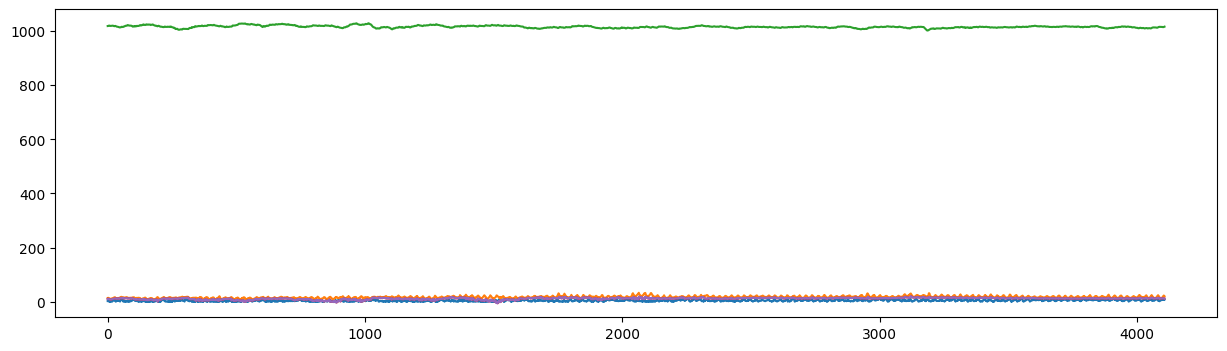

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([4098, 10, 4])


tensor([-0.6867, -0.9489,  0.6450, -0.2746])

In [17]:
class QGRU(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QGRU, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_candidate = [f"wire_candidate_{i}" for i in range(self.n_qubits)]
        self.wires_reset = [f"wire_reset_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        

        self.dev_candidate = qml.device(self.backend, wires=self.wires_candidate)
        self.dev_reset = qml.device(self.backend, wires=self.wires_reset)
        self.dev_update= qml.device(self.backend, wires=self.wires_update)
        

        def _circuit_candidate(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_candidate)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_candidate)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_candidate]
        self.qlayer_candidate = qml.QNode(_circuit_candidate, self.dev_candidate, interface="torch")

        def _circuit_reset(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_reset)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_reset)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_reset]
        self.qlayer_reset = qml.QNode(_circuit_reset, self.dev_reset, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'candidate': qml.qnn.TorchLayer(self.qlayer_candidate, weight_shapes),
            'reset': qml.qnn.TorchLayer(self.qlayer_reset, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        # update gates
        
        
    def forward(self, x, init_states = None):
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(1,batch_size, self.hidden_size).to(x.device)  # hidden state (output)
            c_t = torch.zeros(1,batch_size, self.hidden_size).to(x.device)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            #h_t = h_t[0]
            #c_t = c_t[0]


        for t in range(seq_length):
            if self.batch_first is True: x_t = x[:, t, :]
            else : x_t = x[t, : , :]
            
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            y_t = self.clayer_in(v_t)
            # update gates
            z_t = torch.sigmoid(self.clayer_out(self.VQC['update'](y_t)))
            # reset gates
            r_t = torch.sigmoid(self.clayer_out(self.VQC['reset'](y_t)))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            y_hat_t = self.clayer_in(v_hat_t)
            # candidate for hidden state update

            g_t = torch.tanh(self.clayer_out(self.VQC['candidate'](y_hat_t)))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_seq.append(h_t)
        #hidden_seq = torch.cat(hidden_seq, dim=0)
        #hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        hidden_seq = torch.cat(hidden_seq, dim = 0)
        return hidden_seq, (h_t, c_t)


class QRegressionGRU(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QGRU(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
from collections import OrderedDict
class StackedQLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units,num_layers =2 , n_qubits=0, n_qlayers=1):
        super().__init__()
        label,qlstm = 'Q-GRU', QGRU
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size= num_sensors if i == 0 else hidden_units ,hidden_size=hidden_units, batch_first=True if i == 0 else False,n_qubits = n_qubits,n_qlayers= n_qlayers)) 
                for i in range(num_layers)
        ]))
    def forward(self, inputs, parameters = None):
        outputs = None
        #print(list(enumerate(self.qlstms)))
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
            
        return outputs, parameters

class StackedQLSTMmodel(nn.Module):
    def __init__(self, num_sensors, hidden_units,num_layers = 2, n_qubits=0, n_qlayers=1):
        super(StackedQLSTMmodel, self).__init__()
        
        self.hidden_size = hidden_units
        self.num_layers = num_layers
                
        self.qlstm = StackedQLSTM(num_sensors, hidden_units, num_layers = num_layers,n_qubits = n_qubits,n_qlayers= n_qlayers)
        self.predict = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        out, (hn, _) = self.qlstm(x, (h0, c0))
                
        out = self.predict(out[0]).flatten()
        #out1 = self.predict(hn).flatten()
        
        return out

In [19]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = StackedQLSTMmodel(num_sensors=4, hidden_units= 12, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [20]:
modelQ

StackedQLSTMmodel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (Q-GRU 1): QGRU(
        (clayer_in): Linear(in_features=16, out_features=4, bias=True)
        (clayer_out): Linear(in_features=4, out_features=12, bias=True)
      )
      (Q-GRU 2): QGRU(
        (clayer_in): Linear(in_features=24, out_features=4, bias=True)
        (clayer_out): Linear(in_features=4, out_features=12, bias=True)
      )
    )
  )
  (predict): Linear(in_features=12, out_features=1, bias=True)
)

In [21]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0
def new_func(x):
    output = modelQ(x)
    return output

for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = new_func(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:170.62336927746037 
[2/5]  LossQ:124.70784401610945 
[3/5]  LossQ:123.33953092681259 
[4/5]  LossQ:123.73274019550445 
[5/5]  LossQ:123.33864988718415 


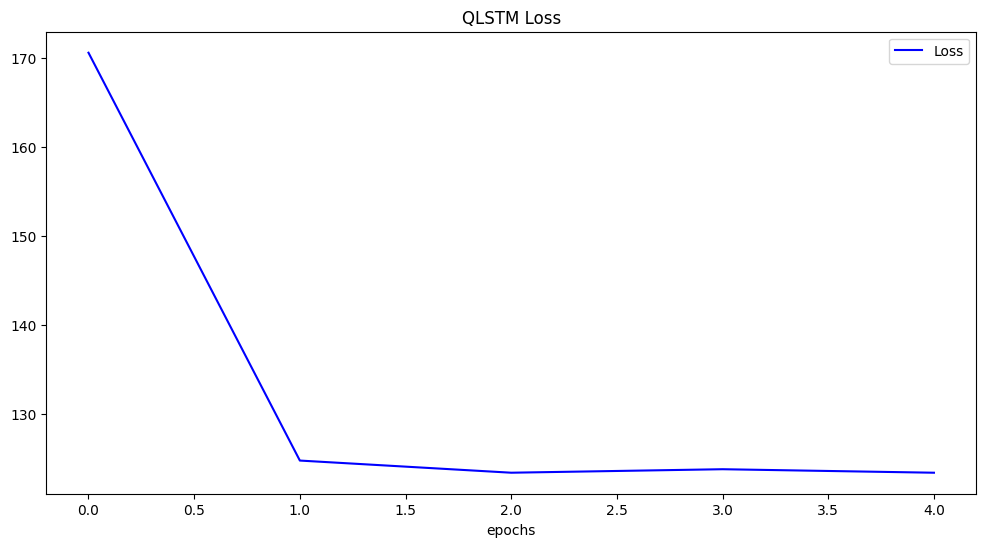

In [22]:
np.savetxt('./SavedModels/Weather/SF/loss/stacked_qgru.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [23]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [24]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.5816, -0.5375, -0.6979,  ...,  0.2588,  0.2504,  0.1552],
       grad_fn=<ViewBackward0>)


In [25]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [26]:
pred_y_train

tensor([[-0.5816],
        [-0.5375],
        [-0.6979],
        ...,
        [ 0.2588],
        [ 0.2504],
        [ 0.1552]], grad_fn=<ViewBackward0>)

In [27]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [28]:
np.savetxt('./SavedModels/Weather/SF/train/stacked_qgru.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/SF/test/stacked_qgru.txt',y_test_pred)

Training dataset RMSE:1.9394370089683528


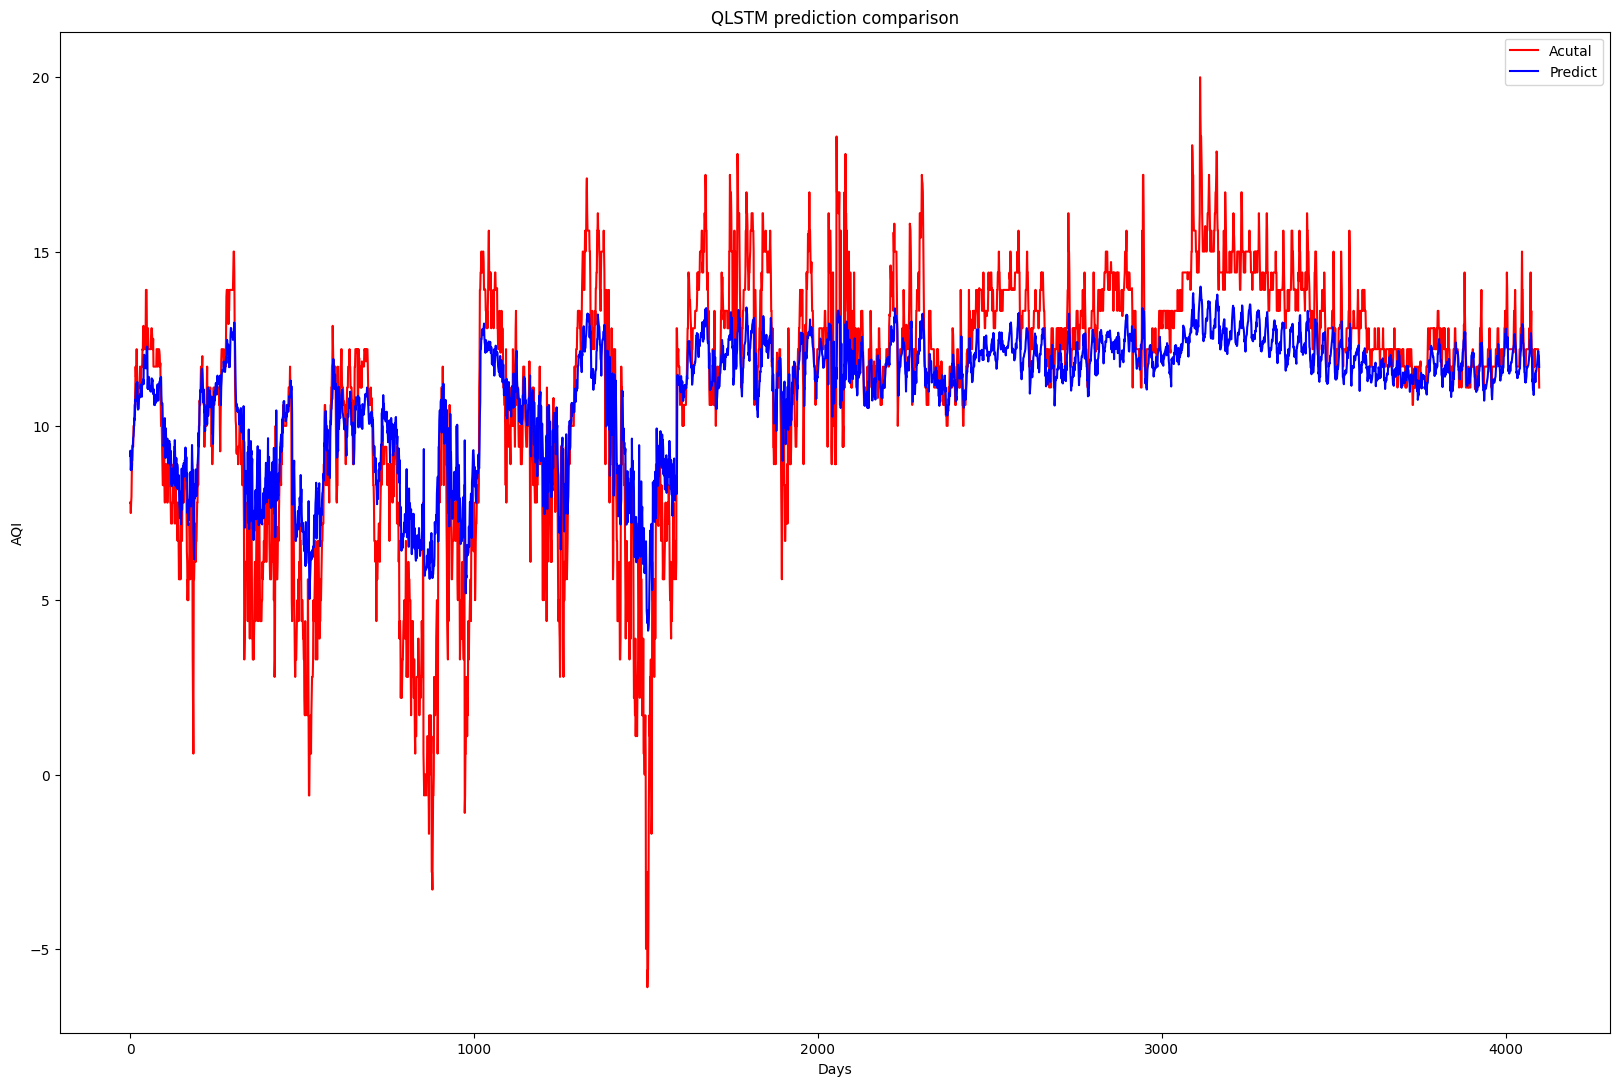

In [29]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.771691459440089


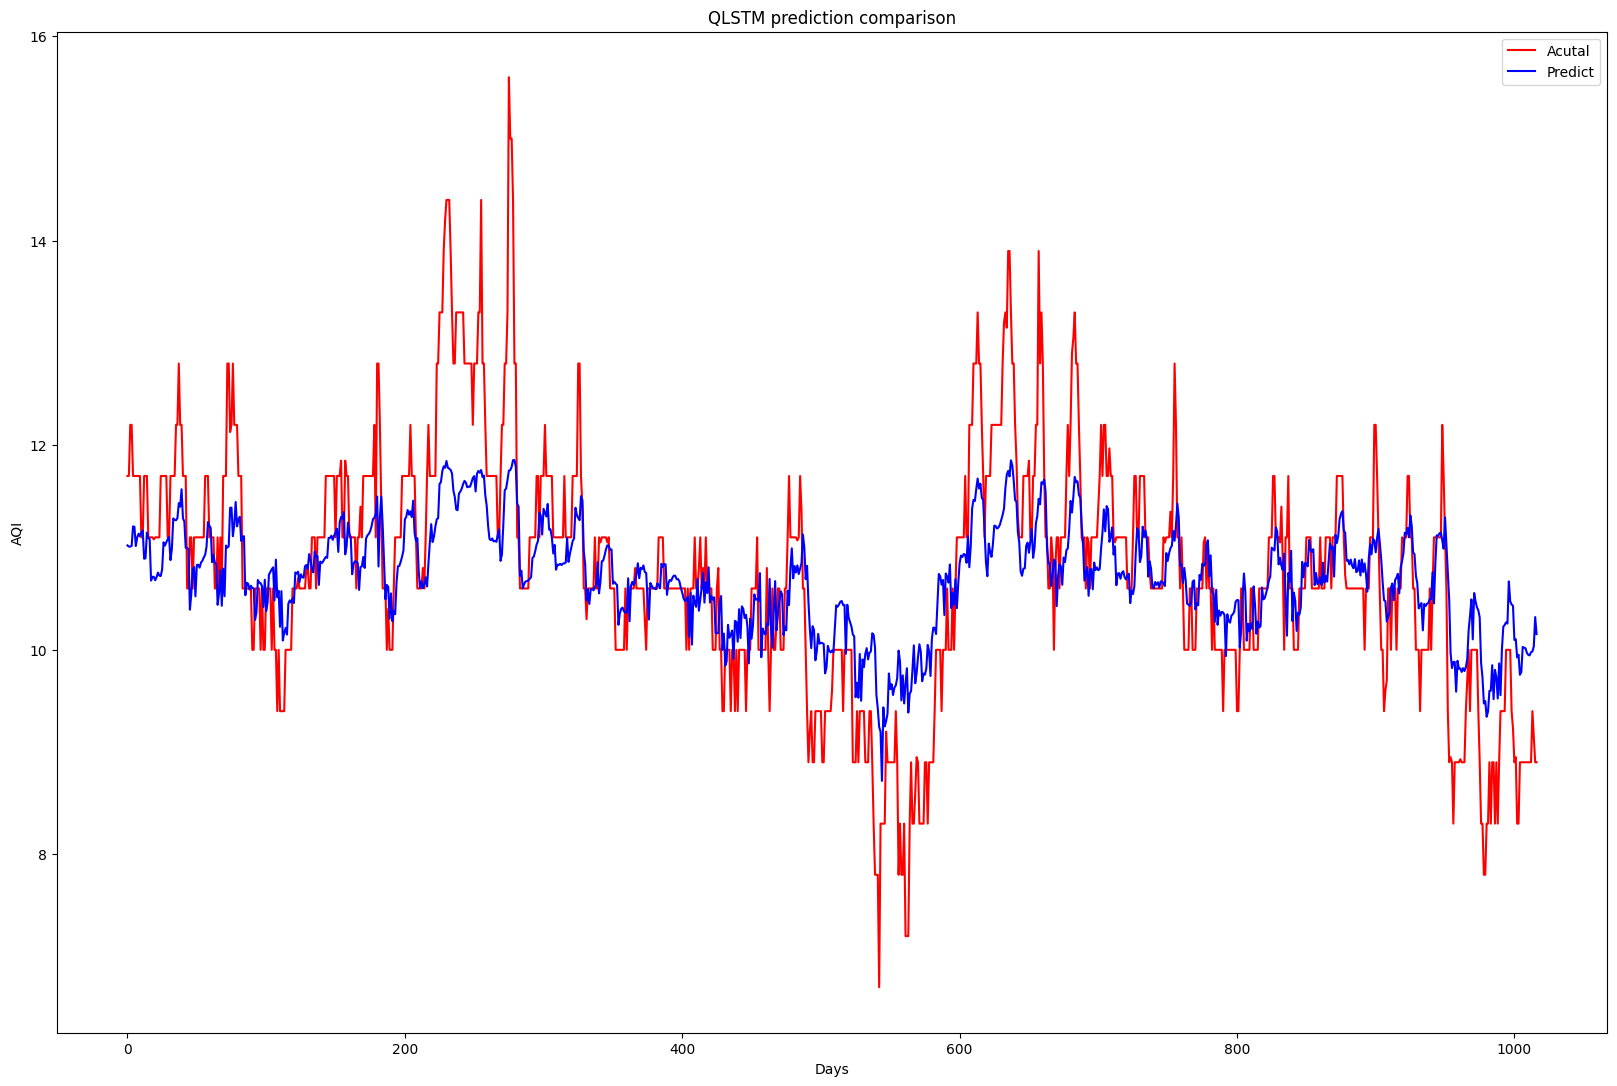

In [30]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [31]:
torch.save(modelQ.state_dict(),'./SavedModels/Weather/SF/model/stacked_QGRU_sd')